# Fetching Simple Electron Data

This notebook is a demo for using the various things to feetch electron data. We are copying a request from the `ServiceX` system. Our backend uses a C++.

Here is the original `ServiceX` request:

`{"_index":"servicex","_type":"docs","_id":"cbHcKWwBMWltPFRM5lOQ","_score":1,"_source":{"name":"Test15","user":"fdc8d58a-2471-42f1-9eed-fb7b2effaf39","description":"Z to ee","dataset":"mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00","columns":["Electrons.pt()","Electrons.eta()"," Electrons.phi()"," Electrons.e()"," Muons.pt()"," Muons.eta()"," Muons.phi()"," Muons.e()"],"events":"0","status":"Validated","created_at":1564070438538,"modified_at":1564071050148,"events_processed":0,"events_served":109500,"kafka_lwm":0,"kafka_hwm":0,"redis_messages":101,"redis_consumers":0,"paused_transforms":true,"info":"Created\n17 files can be accessed.\n0 files can't be accessed.\nTotal size: 74851738602.\nValidated OK","dataset_files":17,"dataset_size":74851738602,"dataset_events":1993800}}`

## Setup

You need to have the `func_adl` package installed. Use the following line to do that.

`blah blah blah`

In [26]:
from adl_func_client.event_dataset import EventDataset
from adl_func_client.use_exe_func_adl_server import use_exe_func_adl_server

import uproot_methods
import matplotlib.pyplot as plt

import datetime

Next thing you need is an endpont. This is for a cache that is setup in a docker container. But you can point directly at the service (the protocal is identical):

In [2]:
end_point = 'http://localhost:30000'

## Fetching the data

In [6]:
ds = EventDataset('localds://mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

In [7]:
leptons_per_event_as = ds \
        .Select('lambda e: (e.Electrons("Electrons"), e.Muons("Muons"))') \
        .Select('lambda ls: (ls[0].Select(lambda e: e.pt()), ls[0].Select(lambda e: e.eta()), ls[0].Select(lambda e: e.phi()), ls[0].Select(lambda e: e.e()),ls[1].Select(lambda m: m.pt()), ls[1].Select(lambda m: m.eta()), ls[1].Select(lambda m: m.phi()), ls[1].Select(lambda m: m.e()))') \
        .AsAwkwardArray(('ElePt', 'EleEta', 'ElePhi', 'EleE', 'MuPt', 'MuEta', 'MuPhi', 'MuE')) \
        .future_value(executor=lambda a: use_exe_func_adl_server(a, node=end_point, quiet=False))

In [8]:
leptons_per_event = await leptons_per_event_as

Files that were returned:
  ['file:///C:\\Users\\gordo\\Documents\\func-adl-cache/40ae9bb8bd6cf8bcb7ae703c715939d7/ANALYSIS_001.root', 'pandas_tree28']


In [15]:
v_particles = uproot_methods.TLorentzVectorArray.from_ptetaphi(
    leptons_per_event[b'ElePt'], leptons_per_event[b'EleEta'],
    leptons_per_event[b'ElePhi'], leptons_per_event[b'EleE'],
    )

In [17]:
v_particles = v_particles[v_particles.counts >= 2]
diparticles = v_particles[:, 0] + v_particles[:, 1]

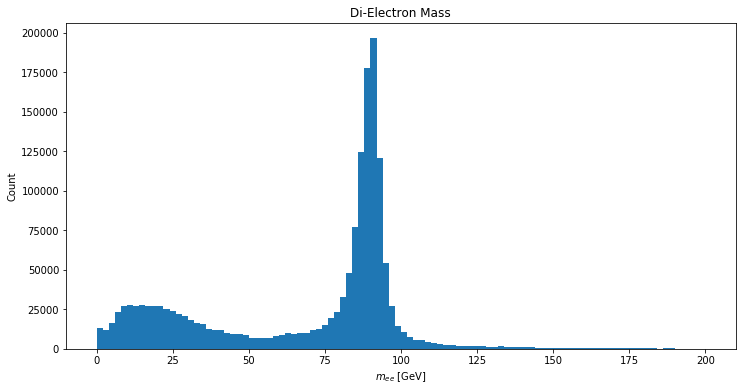

In [39]:
plt.figure(figsize=(12, 6))
plt.hist(diparticles.mass/1000.0, bins=100, range=(0,200))
plt.title('Di-Electron Mass')
plt.xlabel('$m_{ee}$ [GeV]')
plt.ylabel('Count')
plt.show()

In [19]:
len(v_particles)

1603015